# Music2Latent tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/music2latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import os

repo_name = 'onset-benchmark'
repo_path = f'/content/{repo_name}'

if os.getcwd() != repo_path:
    if not os.path.exists(repo_path):
        !git clone https://github.com/inspektral/onset-benchmark.git
    os.chdir(repo_path)
    !pip install -r requirements.txt

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
from music2latent import EncoderDecoder



In [15]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")

Available tests:
0: random_sines
1: saw_noise


In [16]:
SAMPLE_RATE = 44100
CURRENT_TEST = 1


Running test: saw_noise


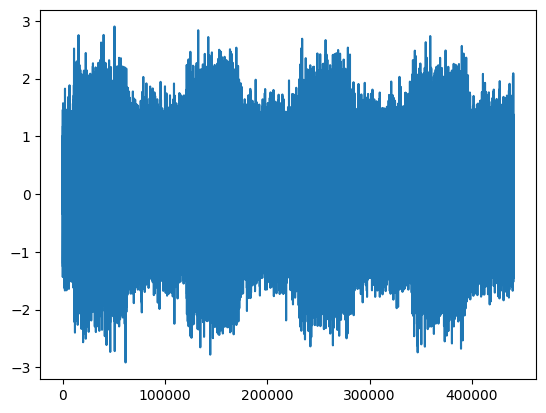

In [17]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
audio = test()

plt.plot(audio)
plt.show()

display(Audio(audio, rate=SAMPLE_RATE))

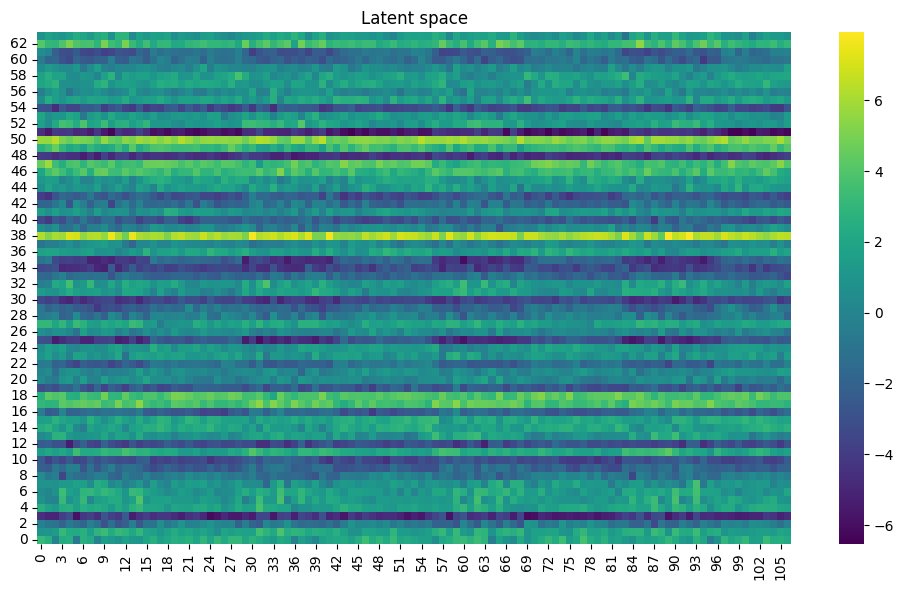

In [25]:
encdec = EncoderDecoder()
latent = encdec.encode(audio)
latent = latent.cpu().numpy()[0,:,:]
utils.plot_heatmap(latent, title="Latent space")

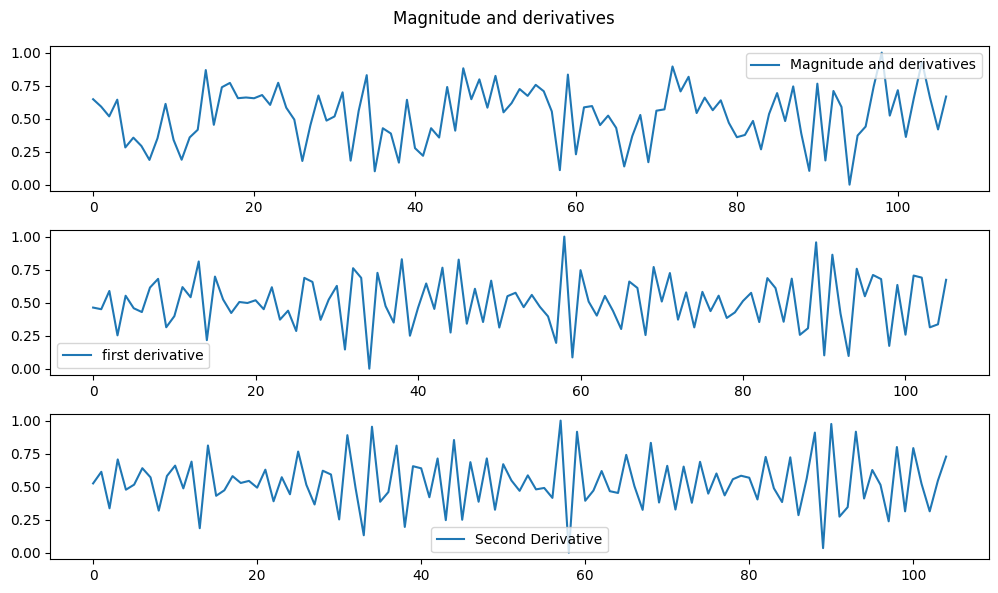

In [26]:

magnitude = np.sum(latent, axis=0)
d_magnitude = np.diff(magnitude)
dd_magnitude = np.diff(d_magnitude)

utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    title="Magnitude and derivatives",
)

distances shape: (64, 106)
max_indices: [19 24 44 56 62  3 40 28 23  8 25 42  0 58 32 38  2  5 35  7]


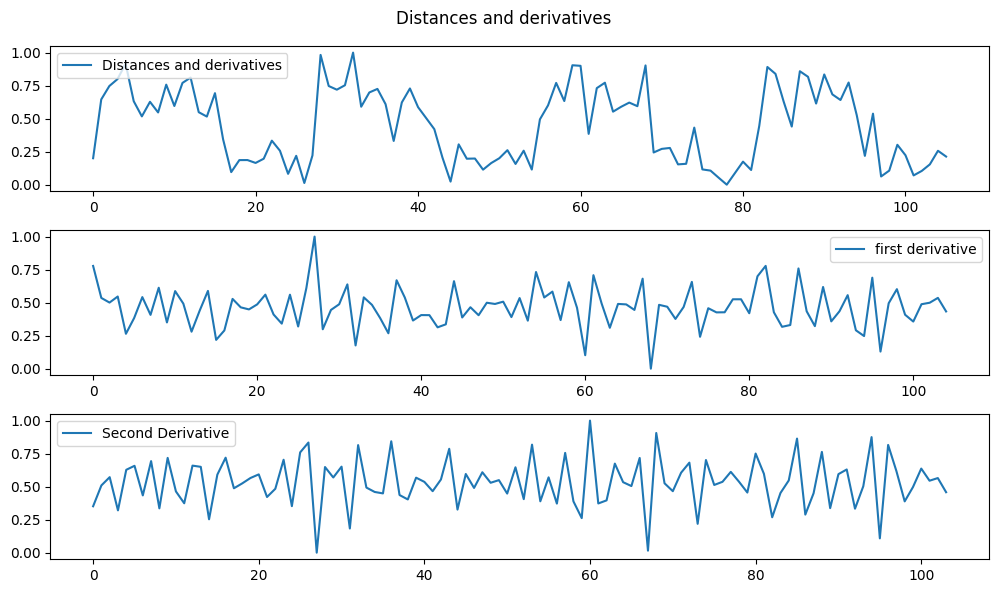

In [27]:
distances = utils.distances(latent, top_n=20)
d_distances = np.diff(distances)
dd_distances = np.diff(d_distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    title="Distances and derivatives",
)


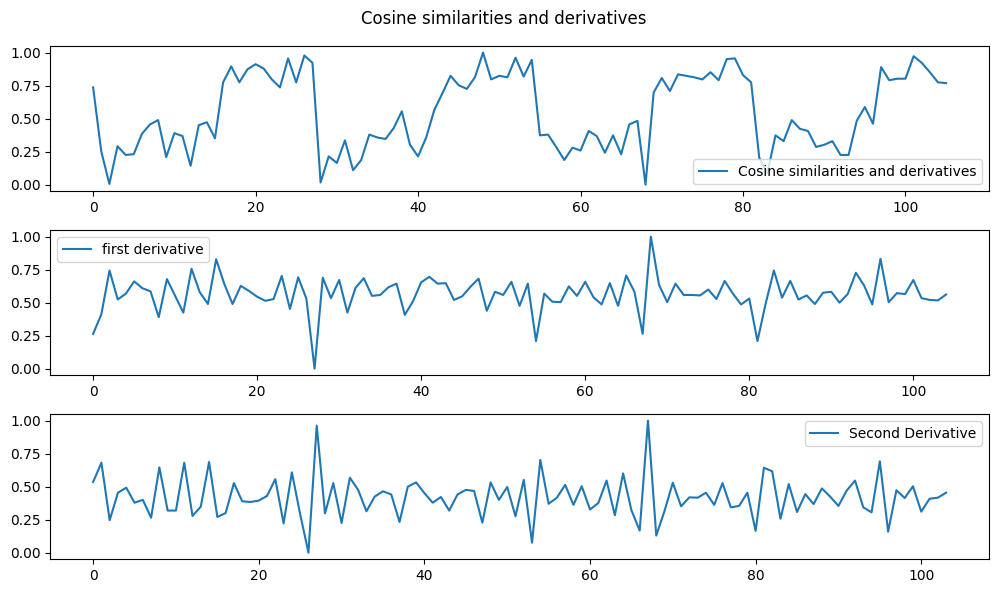

In [29]:
similarities = utils.cosine_similarity(latent)
d_similarities = np.diff(similarities)
dd_similarities = np.diff(d_similarities)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    title="Cosine similarities and derivatives",
)